In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.base import clone

In [2]:
train_df = pd.read_excel("Data/ruc_Class25Q1_train.xlsx")
test_df = pd.read_excel("Data/ruc_Class25Q1_test.xlsx")
details_df = pd.read_excel("Data/ruc_Class25Q1_details.xlsx")
rent_df = pd.read_excel("Data/ruc_Class25Q1_rent.xlsx")

## 1. 数据预处理函数

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# 全局变量，用于在训练和测试之间共享
imputers = {}
freq_map_for_test = {}
encoded_columns = None
feature_list = None
scaler = None
pca = None

def process_data(train_df, test_df, details_df, rent_df, is_training=True):
    """
    处理房价预测数据集，执行特征工程和数据预处理
    
    参数:
    train_df: 训练数据集
    test_df: 测试数据集
    details_df: 小区详细信息数据集
    rent_df: 租赁数据集
    is_training: 是否为训练模式(True)或预测模式(False)
    
    返回:
    X: 处理后的特征数据
    y: 目标变量(仅在训练模式下)
    scaler: 标准化对象(仅在训练模式下)
    pca: PCA对象(仅在训练模式下)
    """
    global imputers, freq_map_for_test, encoded_columns, feature_list, scaler, pca
    
    # 确定当前处理的数据集
    if is_training:
        df = train_df.copy()
    else:
        df = test_df.copy()
        
    # 1. 定义辅助函数
    def extract_area(area_str):
        if pd.isna(area_str):
            return np.nan
        # 移除所有非数字和小数点的字符
        cleaned_str = re.sub(r'[^\d.]', '', str(area_str))
        try:
            return float(cleaned_str) if cleaned_str else np.nan
        except ValueError:
            return np.nan
    
    def extract_floor_info(floor_str):
        if pd.isna(floor_str):
            return np.nan, np.nan
        
        # 提取当前楼层
        current_match = re.search(r'(底层|低楼层|中楼层|高楼层|顶层)', str(floor_str))
        current_floor = current_match.group(1) if current_match else np.nan
        
        # 提取总楼层
        total_match = re.search(r'共(\d+)层', str(floor_str))
        total_floor = int(total_match.group(1)) if total_match else np.nan
        
        return current_floor, total_floor
    
    def extract_house_type(type_str):
        if pd.isna(type_str):
            return np.nan, np.nan, np.nan, np.nan
        
        rooms = re.search(r'(\d+)室', str(type_str))
        rooms = int(rooms.group(1)) if rooms else 0
        
        living_rooms = re.search(r'(\d+)厅', str(type_str))
        living_rooms = int(living_rooms.group(1)) if living_rooms else 0
        
        kitchens = re.search(r'(\d+)厨', str(type_str))
        kitchens = int(kitchens.group(1)) if kitchens else 0
        
        bathrooms = re.search(r'(\d+)卫', str(type_str))
        bathrooms = int(bathrooms.group(1)) if bathrooms else 0
        
        return rooms, living_rooms, kitchens, bathrooms
    
    def extract_number(x):
        if pd.isna(x) or not isinstance(x, str):
            return np.nan
        match = re.search(r'(\d+\.?\d*)', x)
        if match:
            return float(match.group(1))
        return np.nan
    
    # 2. 处理面积数据
    df['建筑面积_数值'] = df['建筑面积'].apply(extract_area)
    df['套内面积_数值'] = df['套内面积'].apply(extract_area)
    
    # 3. 处理楼层信息
    floor_info = df['所在楼层'].apply(extract_floor_info)
    df['当前楼层'] = [x[0] for x in floor_info]
    df['总楼层'] = [x[1] for x in floor_info]
    
    # 4. 处理户型信息
    house_type_info = df['房屋户型'].apply(extract_house_type)
    df['房间数'] = [x[0] for x in house_type_info]
    df['客厅数'] = [x[1] for x in house_type_info]
    df['厨房数'] = [x[2] for x in house_type_info]
    df['卫生间数'] = [x[3] for x in house_type_info]
    
    # 5. 创建楼层比例特征
    floor_map = {'底层': 0, '低楼层': 0.25, '中楼层': 0.5, '高楼层': 0.75, '顶层': 1}
    df['楼层比例'] = df['当前楼层'].map(floor_map)
    
    # 6. 处理电梯
    df['有电梯'] = df['配备电梯'].map({'有': 1, '无': 0})
    
    # 7. 与小区详情合并
    merged_df = pd.merge(df, details_df, left_on=['小区名称', '城市'], right_on=['名称', '城市'], how='left')
    
    # 8. 提取小区建筑年代
    merged_df['建筑年代_数值'] = merged_df['建筑年代'].str.extract(r'(\d+)').astype(float)
    
    # 9. 提取容积率和绿化率
    merged_df['容积率_数值'] = merged_df['容 积 率'].apply(extract_number)
    merged_df['绿化率_数值'] = merged_df['绿 化 率'].apply(lambda x: extract_number(x)/100 if pd.notna(x) and isinstance(x, str) and '%' in x else extract_number(x))
    
    # 10. 计算房龄
    current_year = 2025  # 假设当前年份为2024年
    merged_df['房龄'] = current_year - merged_df['建筑年代_数值']
    
    # 11. 与租赁数据合并
    rent_avg = rent_df.groupby('小区名称')['价格'].mean().reset_index()
    rent_avg.rename(columns={'价格': '平均租金'}, inplace=True)
    merged_df = pd.merge(merged_df, rent_avg, on='小区名称', how='left')
    
    # 12. 计算租售比 (只在训练集或包含价格信息时计算)
    if is_training or '价格' in merged_df.columns:
        merged_df['租售比'] = merged_df['平均租金'] / merged_df['价格']
    
    # 13. 频率编码
    if is_training:
        # 在训练集上计算频率
        freq_map = merged_df['板块_x'].value_counts(normalize=True).to_dict()
        # 保存频率映射，以便应用到测试集
        freq_map_for_test = freq_map
    else:
        # 使用训练集上计算的频率映射
        freq_map = freq_map_for_test
    
    merged_df['板块_x_freq'] = merged_df['板块_x'].map(freq_map)
    
    # 14. 删除不需要的列和有数据泄露的列
    cols_to_drop = ['套内面积', '所在楼层', '房屋户型', '配备电梯', '名称', '建筑年代', 
                   '容 积 率', '绿 化 率', '物 业 费', '核心卖点', '户型介绍', '周边配套', '交通出行','建筑面积']
    processed_df = merged_df.drop(columns=cols_to_drop, errors='ignore')
    
    # 15. 处理缺失值
    # 获取数值型列
    numeric_cols = processed_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if is_training and '价格' in numeric_cols:
        numeric_cols.remove('价格')
    
    # 重要修改：先创建所有列的imputer，然后再应用
    if is_training:
        # 初始化存储所有列的imputer
        imputers = {}
        for col in numeric_cols:
            if processed_df[col].isnull().any():
                imputer = SimpleImputer(strategy='median')
                imputer.fit(processed_df[col].values.reshape(-1, 1))
                imputers[col] = imputer
    
    # 应用imputer进行缺失值填充
    for col in numeric_cols:
        if processed_df[col].isnull().any():
            if col in imputers:
                # 使用已有的imputer填充
                processed_df[col] = imputers[col].transform(processed_df[col].values.reshape(-1, 1))
            else:
                # 如果没有这个列的imputer(新列或测试集特有的列)，使用当前数据的中位数填充
                median_val = processed_df[col].median()
                processed_df[col].fillna(median_val, inplace=True)
    
    # 16. 处理分类特征
    categorical_features_to_use = ['城市', '区域', '板块_x_freq', '环线', '装修情况', '当前楼层', '房屋朝向', '建筑结构_x', '别墅类型']
    # 过滤存在于数据中的分类特征
    categorical_features_to_use = [col for col in categorical_features_to_use if col in processed_df.columns]
    
    # 使用get_dummies进行One-Hot编码
    if is_training:
        # 在训练集上进行独热编码
        processed_df_encoded = pd.get_dummies(processed_df, columns=categorical_features_to_use, drop_first=True)
        # 保存编码的列，以便应用到测试集
        encoded_columns = processed_df_encoded.columns
    else:
        # 在测试集上进行独热编码，确保列与训练集相同
        processed_df_encoded = pd.get_dummies(processed_df, columns=categorical_features_to_use, drop_first=True)
        
        # 确保测试集与训练集具有相同的特征列
        for col in encoded_columns:
            if col not in processed_df_encoded.columns:
                processed_df_encoded[col] = 0
        
        # 测试集可能有训练集没有的列，需要移除
        extra_cols = [col for col in processed_df_encoded.columns if col not in encoded_columns]
        if extra_cols:
            processed_df_encoded = processed_df_encoded.drop(columns=extra_cols)
        
        # 确保列的顺序一致
        processed_df_encoded = processed_df_encoded[encoded_columns.intersection(processed_df_encoded.columns)]
    
    # 17. 特征选择 - 选择用于训练的特征
    # 移除不用于训练的列和冗余特征
    columns_to_exclude = [
        # 识别信息
        '小区名称', '小区地址', '区县', 
        
        # 冗余或潜在数据泄露特征
        '板块_y', '建筑结构_y', '物业办公电话', '产权描述',
        '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用',
        
        # 已经转换为数值的特征原始列
        '梯户比例', '交易时间', '交易权属', '上次交易', '房屋用途', '产权所属', 
        '抵押信息', '房屋年限', '环线位置',
        
        # 已有提取特征的原始数据
        '开发商', '物业公司', '物业类别', '房屋优势', '房屋总数', '楼栋总数',
        
        # 可能与其他特征重复的坐标
        'coord_x', 'coord_y', '板块_x'
    ]
    
    # 获取特征列表
    if is_training:
        features = [col for col in processed_df_encoded.columns if col not in columns_to_exclude and col != '价格']
        feature_list = features
    else:
        features = [col for col in feature_list if col in processed_df_encoded.columns]
    
    # 确保所有特征都存在于处理后的数据中
    for col in features:
        if col not in processed_df_encoded.columns:
            processed_df_encoded[col] = 0  # 如果缺少某列，用0填充
    
    X = processed_df_encoded[features]
    
    # 18. 添加非线性特征
    # 确保这些基础特征存在
    base_features = ['建筑面积_数值', '房间数', '客厅数', '厨房数', '卫生间数', '总楼层', '房龄']
    for feat in base_features:
        if feat not in X.columns:
            X[feat] = 0  # 使用0填充缺失的基础特征
    
    X['建筑面积_平方'] = X['建筑面积_数值'] ** 2
    X['建筑面积_平方根'] = np.sqrt(X['建筑面积_数值'])
    
    # 特征交互 - 增加错误处理
    # 避免除以零
    X['房间密度'] = (X['房间数'] + X['客厅数'] + X['厨房数'] + X['卫生间数']) / X['建筑面积_数值'].replace(0, 1)
    X['平均每房面积'] = X['建筑面积_数值'] / X['房间数'].replace(0, 1)
    X['楼层面积比'] = X['总楼层'] / X['建筑面积_数值'].replace(0, 1)
    X['房龄平方'] = X['房龄'] ** 2
    
    # 19. 标准化特征
    if is_training:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 可选: PCA降维
        pca = PCA(n_components=0.95)  # 保留95%的方差
        X_pca = pca.fit_transform(X_scaled)
        
        # 获取目标变量
        y = processed_df_encoded['价格'] if '价格' in processed_df_encoded.columns else None
        
        return X, X_scaled, X_pca, y, scaler, pca, feature_list
    else:
        # 使用训练集的scaler
        X_scaled = scaler.transform(X)
        
        # 使用训练集的PCA
        X_pca = pca.transform(X_scaled)
        
        return X, X_scaled, X_pca

In [4]:
# 使用示例:
# 训练模式:
X, X_scaled, X_pca, y, scaler, pca, feature_list = process_data(train_df, test_df, details_df, rent_df, is_training=True)



In [5]:
# 测试模式:
X_test, X_test_scaled, X_test_pca = process_data(train_df, test_df, details_df, rent_df, is_training=False)

In [6]:
# 划分训练集和测试集
X_train, X_test, X_train_scaled, X_test_scaled, X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X, X_scaled, X_pca, y, test_size=0.2, random_state=111
)

print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")
print(f"PCA特征数量: {X_train_pca.shape[1]}")

训练集形状: (67683, 562)
测试集形状: (16921, 562)
PCA特征数量: 440


## 2. models

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """评估模型性能，包括样本内外性能和交叉验证"""
    start_time = time.time()
    print(f"\n开始训练 {model_name}...")
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 样本内预测
    y_train_pred = model.predict(X_train)
    
    # 样本外预测
    y_test_pred = model.predict(X_test)
    
    # 计算MAE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # 计算RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # 计算R2
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 6折交叉验证
    print(f"执行 {model_name} 的6折交叉验证...")
    cv = KFold(n_splits=6, shuffle=True, random_state=111)
    
    # 使用手动循环代替cross_val_score以添加进度条
    cv_mae_scores = []
    cv_rmse_scores = []
    cv_r2_scores = []
    
    for train_idx, val_idx in tqdm(cv.split(X_train), total=6, desc="交叉验证进度"):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 训练模型
        model_cv = clone(model)
        model_cv.fit(X_cv_train, y_cv_train)
        
        # 预测
        y_cv_pred = model_cv.predict(X_cv_val)
        
        # 计算指标
        cv_mae_scores.append(mean_absolute_error(y_cv_val, y_cv_pred))
        cv_rmse_scores.append(np.sqrt(mean_squared_error(y_cv_val, y_cv_pred)))
        cv_r2_scores.append(r2_score(y_cv_val, y_cv_pred))
    
    # 计算平均分数
    cv_mae = np.mean(cv_mae_scores)
    cv_rmse = np.mean(cv_rmse_scores)
    cv_r2 = np.mean(cv_r2_scores)
    
    # 计算训练时间
    training_time = time.time() - start_time
    
    # 输出结果
    print(f"\n{model_name} 评估结果:")
    print(f"训练时间: {training_time:.2f}秒")
    print(f"In-sample MAE: {train_mae:.4f}")
    print(f"Out-of-sample MAE: {test_mae:.4f}")
    print(f"CV MAE: {cv_mae:.4f}")
    print(f"In-sample RMSE: {train_rmse:.4f}")
    print(f"Out-of-sample RMSE: {test_rmse:.4f}")
    print(f"CV RMSE: {cv_rmse:.4f}")
    print(f"In-sample R²: {train_r2:.4f}")
    print(f"Out-of-sample R²: {test_r2:.4f}")
    print(f"CV R²: {cv_r2:.4f}")
    print("-" * 50)
    
    return {
        'model_name': model_name,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mae': cv_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'cv_rmse': cv_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_r2': cv_r2,
        'training_time': training_time,
        'model': model
    }

In [9]:
def train_models(X_train, X_test, y_train, y_test, use_pca=True):
    """训练多个模型并返回评估结果"""
    models = []
    
    # 选择使用原始特征还是PCA特征
    X_train_data = X_train_pca if use_pca else X_train_scaled
    X_test_data = X_test_pca if use_pca else X_test_scaled
    
    # 线性回归（OLS）
    suffix = "(PCA)" if use_pca else ""
    ols = LinearRegression()
    ols_results = evaluate_model(ols, X_train_data, X_test_data, y_train, y_test, f"OLS {suffix}")
    models.append(ols_results)
    
    # Lasso回归（L1正则化） -  # 增大alpha值, 减少最大迭代次数
    lasso = Lasso(alpha=1.0, max_iter=500, tol=0.1, warm_start=True, random_state=111)
    lasso_results = evaluate_model(lasso, X_train_data, X_test_data, y_train, y_test, f"Lasso {suffix}")
    models.append(lasso_results)
    
    # Ridge回归（L2正则化）
    ridge = Ridge(alpha=1.0, random_state=111)
    ridge_results = evaluate_model(ridge, X_train_data, X_test_data, y_train, y_test, f"Ridge {suffix}")
    models.append(ridge_results)
    
    # ElasticNet（结合L1和L2正则化）
    elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=111)
    elastic_results = evaluate_model(elastic, X_train_data, X_test_data, y_train, y_test, f"ElasticNet {suffix}")
    models.append(elastic_results)
    
    # 按测试集MAE排序
    sorted_models = sorted(models, key=lambda x: x['test_mae'])
    best_model = sorted_models[0]
    
    print(f"\n总体最佳模型: {best_model['model_name']}，测试集MAE: {best_model['test_mae']:.4f}")
    
    return {
        'models': models,
        'best_model': best_model,
        'ols_results': ols_results,
        'lasso_results': lasso_results,
        'ridge_results': ridge_results,
        'elastic_results': elastic_results
    }

In [10]:
# 训练和评估模型
print("\n使用PCA特征训练模型...")
pca_models_results = train_models(X_train_pca, X_test_pca, y_train, y_test, use_pca=True)

print("\n使用原始特征训练模型...")
models_results = train_models(X_train_scaled, X_test_scaled, y_train, y_test, use_pca=False)


使用PCA特征训练模型...

开始训练 OLS (PCA)...
执行 OLS (PCA) 的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.10s/it]



OLS (PCA) 评估结果:
训练时间: 22.10秒
In-sample MAE: 664804.2773
Out-of-sample MAE: 1475949.1570
CV MAE: 2855516.8685
In-sample RMSE: 1213244.6147
Out-of-sample RMSE: 44549921.7844
CV RMSE: 113242442.4588
In-sample R²: 0.7888
Out-of-sample R²: -289.3447
CV R²: -3039.3228
--------------------------------------------------

开始训练 Lasso (PCA)...
执行 Lasso (PCA) 的6折交叉验证...


交叉验证进度: 100%|█████████████████████████████████████████████████████████████████████| 6/6 [18:10<00:00, 181.70s/it]



Lasso (PCA) 评估结果:
训练时间: 1281.03秒
In-sample MAE: 667351.6553
Out-of-sample MAE: 867878.9167
CV MAE: 869443.6682
In-sample RMSE: 1233408.4960
Out-of-sample RMSE: 11167299.8197
CV RMSE: 8806573.3186
In-sample R²: 0.7817
Out-of-sample R²: -17.2438
CV R²: -11.5845
--------------------------------------------------

开始训练 Ridge (PCA)...
执行 Ridge (PCA) 的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.33s/it]



Ridge (PCA) 评估结果:
训练时间: 24.59秒
In-sample MAE: 663379.7899
Out-of-sample MAE: 1405480.2213
CV MAE: 1678755.4594
In-sample RMSE: 1213447.7857
Out-of-sample RMSE: 40242440.3763
CV RMSE: 44037663.9779
In-sample R²: 0.7887
Out-of-sample R²: -235.9129
CV R²: -314.0449
--------------------------------------------------

开始训练 ElasticNet (PCA)...
执行 ElasticNet (PCA) 的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████| 6/6 [1:47:18<00:00, 1073.06s/it]



ElasticNet (PCA) 评估结果:
训练时间: 7020.21秒
In-sample MAE: 673514.8872
Out-of-sample MAE: 720386.1171
CV MAE: 729416.8396
In-sample RMSE: 1248214.6675
Out-of-sample RMSE: 2831958.0468
CV RMSE: 2660178.8920
In-sample R²: 0.7764
Out-of-sample R²: -0.1733
CV R²: -0.0977
--------------------------------------------------

总体最佳模型: ElasticNet (PCA)，测试集MAE: 720386.1171

使用原始特征训练模型...

开始训练 OLS ...
执行 OLS  的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.97s/it]



OLS  评估结果:
训练时间: 22.16秒
In-sample MAE: 536329.5005
Out-of-sample MAE: 543254.7146
CV MAE: 560772.0751
In-sample RMSE: 1061250.0655
Out-of-sample RMSE: 1102353.0933
CV RMSE: 2460316.5460
In-sample R²: 0.8384
Out-of-sample R²: 0.8222
CV R²: -1.1644
--------------------------------------------------

开始训练 Lasso ...
执行 Lasso  的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]



Lasso  评估结果:
训练时间: 12.00秒
In-sample MAE: 550608.3519
Out-of-sample MAE: 554880.4467
CV MAE: 593488.6048
In-sample RMSE: 1100060.7694
Out-of-sample RMSE: 1163993.5064
CV RMSE: 3849103.1528
In-sample R²: 0.8263
Out-of-sample R²: 0.8018
CV R²: -6.2875
--------------------------------------------------

开始训练 Ridge ...
执行 Ridge  的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/it]



Ridge  评估结果:
训练时间: 8.21秒
In-sample MAE: 536024.4588
Out-of-sample MAE: 543295.1397
CV MAE: 558662.7372
In-sample RMSE: 1061558.5081
Out-of-sample RMSE: 1103216.7037
CV RMSE: 2306349.4897
In-sample R²: 0.8383
Out-of-sample R²: 0.8220
CV R²: -0.7811
--------------------------------------------------

开始训练 ElasticNet ...
执行 ElasticNet  的6折交叉验证...


交叉验证进度: 100%|██████████████████████████████████████████████████████████████████| 6/6 [2:18:12<00:00, 1382.02s/it]


ElasticNet  评估结果:
训练时间: 9663.52秒
In-sample MAE: 537963.0651
Out-of-sample MAE: 545050.7941
CV MAE: 547521.1254
In-sample RMSE: 1066702.4473
Out-of-sample RMSE: 1108328.1722
CV RMSE: 1197340.6291
In-sample R²: 0.8367
Out-of-sample R²: 0.8203
CV R²: 0.7886
--------------------------------------------------

总体最佳模型: OLS ，测试集MAE: 543254.7146


## 3. Submission

In [11]:
import os

In [19]:
def generate_submissions_for_all_models(models_results, X_test_data, X_test_data_scaled, X_test_data_pca, test_df):
    """
    为多个模型生成单独的提交文件
    
    参数:
    models_results: 模型评估结果列表
    X_test_data: 未缩放的测试特征
    X_test_data_scaled: 缩放后的测试特征
    X_test_data_pca: PCA降维后的测试特征
    test_df: 原始测试数据框
    
    返回:
    submissions_info: 包含每个模型及其提交文件路径的字典
    """
    # 创建submissions目录（如果不存在）
    os.makedirs('submissions_whole', exist_ok=True)
    
    # 获取ID列
    id_column = test_df.iloc[:, 0].values if 'ID' not in test_df.columns else test_df['ID'].values
    print(f"ID列长度: {len(id_column)}")
    
    submissions_info = {}
    
    for result in models_results:
        model = result['model']
        model_name = result['model_name']
        
        # 根据模型类型选择合适的特征集
        if 'LightGBM' in model_name or 'XGBoost' in model_name:
            # 梯度提升模型通常使用原始特征
            features_to_use = X_test_data
            feature_type = "原始特征"
        elif 'PCA' in model_name:
            # PCA模型使用PCA降维后的特征
            features_to_use = X_test_data_pca
            feature_type = "PCA特征"
        else:
            # 默认线性模型使用缩放后的特征
            features_to_use = X_test_data_scaled
            feature_type = "缩放特征"
        
        print(f"\n为 {model_name} 生成提交文件，使用{feature_type}...")
        print(f"特征形状: {features_to_use.shape}")
        
        try:
            # 使用模型预测
            predictions = model.predict(features_to_use)
            print(f"预测结果长度: {len(predictions)}")
            
            # 确保ID和预测长度相同
            if len(predictions) != len(id_column):
                print(f"警告: 预测数量({len(predictions)})与ID数量({len(id_column)})不匹配")
                
                # 处理不匹配的情况
                if len(predictions) < len(id_column):
                    # 如果预测少于ID，使用平均值填充缺失的预测
                    print("使用平均值填充缺失的预测...")
                    mean_pred = np.mean(predictions)
                    full_predictions = np.ones(len(id_column)) * mean_pred
                    full_predictions[:len(predictions)] = predictions
                    predictions = full_predictions
                else:
                    # 如果预测多于ID，截断多余的预测
                    print("截断多余的预测...")
                    predictions = predictions[:len(id_column)]
            
            # 创建提交数据框
            submission_df = pd.DataFrame({
                'ID': id_column,
                'Price': predictions
            })
            
            # 生成唯一的文件名
            # 替换模型名称中的特殊字符
            safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '')
            filename = f"submissions_whole/{safe_name}_submission.csv"
            
            # 保存提交文件
            submission_df.to_csv(filename, index=False)
            print(f"已保存到 {filename}")
            
            # 记录提交信息
            submissions_info[model_name] = {
                'filename': filename,
                'mean_prediction': np.mean(predictions),
                'min_prediction': np.min(predictions),
                'max_prediction': np.max(predictions)
            }
            
        except Exception as e:
            print(f"为 {model_name} 生成提交文件时出错: {e}")
    
    # 创建摘要表
    summary_df = pd.DataFrame([
        {
            'Model': model_name,
            'Filename': info['filename'],
            'Mean Prediction': info['mean_prediction'],
            'Min Prediction': info['min_prediction'],
            'Max Prediction': info['max_prediction']
        }
        for model_name, info in submissions_info.items()
    ])
    
    print("\n提交文件摘要:")
    print(summary_df)
    
    return submissions_info

In [14]:
# 提取所有需要的模型结果
ols_pca_result = next((r for r in pca_models_results['models'] if 'OLS' in r['model_name']), None)
lasso_pca_result = next((r for r in pca_models_results['models'] if 'Lasso' in r['model_name']), None)
ridge_pca_result = next((r for r in pca_models_results['models'] if 'Ridge' in r['model_name']), None)
elastic_pca_result = next((r for r in pca_models_results['models'] if 'ElasticNet' in r['model_name']), None)
best_model = pca_models_results['best_model']

In [17]:
# 将所有模型结果合并到一个列表中
all_models_pca = [
    ols_pca_result, 
    lasso_pca_result, 
    ridge_pca_result, 
    elastic_pca_result, 
    best_model
]

# 过滤掉None值，以防某些模型没有结果
all_models_pca = [model for model in all_models_pca if model is not None]

In [20]:
# 为所有模型生成提交文件
submissions_info = generate_submissions_for_all_models(
    models_results=all_models_pca,
    X_test_data=X_test,
    X_test_data_scaled=X_test_scaled,
    X_test_data_pca=X_test_pca,
    test_df=test_df
)

ID列长度: 14786

为 OLS (PCA) 生成提交文件，使用PCA特征...
特征形状: (16921, 440)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/OLS_PCA_submission.csv

为 Lasso (PCA) 生成提交文件，使用PCA特征...
特征形状: (16921, 440)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/Lasso_PCA_submission.csv

为 Ridge (PCA) 生成提交文件，使用PCA特征...
特征形状: (16921, 440)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/Ridge_PCA_submission.csv

为 ElasticNet (PCA) 生成提交文件，使用PCA特征...
特征形状: (16921, 440)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/ElasticNet_PCA_submission.csv

为 ElasticNet (PCA) 生成提交文件，使用PCA特征...
特征形状: (16921, 440)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/ElasticNet_PCA_submission.csv

提交文件摘要:
              Model                                         Filename  \
0         OLS (PCA)         submissions_whole/OLS_PCA_submission.csv   
1       Lasso (PCA)       submissions_

In [21]:
# 提取所有需要的模型结果
ols_result = next((r for r in models_results['models'] if 'OLS' in r['model_name']), None)
lasso_result = next((r for r in models_results['models'] if 'Lasso' in r['model_name']), None)
ridge_result = next((r for r in models_results['models'] if 'Ridge' in r['model_name']), None)
elastic_result = next((r for r in models_results['models'] if 'ElasticNet' in r['model_name']), None)
best_model = models_results['best_model']

In [22]:
# 将所有模型结果合并到一个列表中
all_models = [
    ols_result, 
    lasso_result, 
    ridge_result, 
    elastic_result, 
    best_model
]

# 过滤掉None值，以防某些模型没有结果
all_models = [model for model in all_models if model is not None]

In [23]:
# 为所有模型生成提交文件
submissions_info = generate_submissions_for_all_models(
    models_results=all_models,
    X_test_data=X_test,
    X_test_data_scaled=X_test_scaled,
    X_test_data_pca=X_test_pca,
    test_df=test_df
)

ID列长度: 14786

为 OLS  生成提交文件，使用缩放特征...
特征形状: (16921, 562)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/OLS__submission.csv

为 Lasso  生成提交文件，使用缩放特征...
特征形状: (16921, 562)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/Lasso__submission.csv

为 Ridge  生成提交文件，使用缩放特征...
特征形状: (16921, 562)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/Ridge__submission.csv

为 ElasticNet  生成提交文件，使用缩放特征...
特征形状: (16921, 562)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/ElasticNet__submission.csv

为 OLS  生成提交文件，使用缩放特征...
特征形状: (16921, 562)
预测结果长度: 16921
警告: 预测数量(16921)与ID数量(14786)不匹配
截断多余的预测...
已保存到 submissions_whole/OLS__submission.csv

提交文件摘要:
         Model                                      Filename  Mean Prediction  \
0         OLS          submissions_whole/OLS__submission.csv     1.968741e+06   
1       Lasso        submissions_whole/Lasso__submission.csv     1.969623e+06  

In [31]:
def generate_predictions_for_submission_improved(best_model, X_test_features, test_df):
    """为提交生成预测结果，并处理ID和预测值长度不匹配问题以及负值房价问题"""
    print("\n为提交生成预测结果...")
    print(f"测试特征形状: {X_test_features.shape}")
    print(f"测试数据形状: {test_df.shape}")
    
    # 使用最佳模型预测测试集
    predictions = best_model.predict(X_test_features)
    print(f"预测结果长度: {len(predictions)}")
    print(f"原始预测统计: 最小值={np.min(predictions):.2f}, 最大值={np.max(predictions):.2f}, 平均值={np.mean(predictions):.2f}")
    
    # 处理负值房价 - 将所有负值替换为正值
    negative_count = np.sum(predictions < 0)
    if negative_count > 0:
        print(f"警告: 发现{negative_count}个负值房价预测，进行修正...")
        
        # 将负值替换为正值中的最小值
        min_positive = np.min(predictions[predictions > 0]) if np.any(predictions > 0) else 0
        predictions[predictions < 0] = min_positive
        
    
    print(f"修正后预测统计: 最小值={np.min(predictions):.2f}, 最大值={np.max(predictions):.2f}, 平均值={np.mean(predictions):.2f}")
    
    # 获取ID列
    id_column = test_df.iloc[:, 0].values if 'ID' not in test_df.columns else test_df['ID'].values
    print(f"ID列长度: {len(id_column)}")
    
    # 确保ID列和预测结果长度匹配
    if len(id_column) != len(predictions):
        print("警告: ID列和预测结果长度不匹配。进行精细匹配...")
        
        if len(id_column) < len(predictions):
            # 情况1: ID少于预测 - 截取前N个预测，其中N是ID的数量
            print("ID数量少于预测数量，截取前面的预测结果...")
            predictions = predictions[:len(id_column)]
        else:
            # 情况2: 预测少于ID - 使用最后一个预测值填充剩余ID
            print("预测数量少于ID数量，使用最后一个预测值填充...")
            last_prediction = predictions[-1]
            # 创建一个新的预测数组，长度与ID列相同
            new_predictions = np.zeros(len(id_column))
            # 填充已有的预测
            new_predictions[:len(predictions)] = predictions
            # 使用最后一个预测值填充剩余部分
            new_predictions[len(predictions):] = last_prediction
            predictions = new_predictions
    
    # 确保predictions与id_column长度相同
    assert len(predictions) == len(id_column), "预测结果和ID列长度仍然不匹配"
    
    # 创建提交文件
    submission_df = pd.DataFrame({
        'ID': id_column,
        'Price': predictions
    })
    
    # 确保目录存在
    import os
    os.makedirs('submissions_improved', exist_ok=True)
    
    # 保存提交文件
    submission_file = 'submissions_improved/submission_1.csv'
    submission_df.to_csv(submission_file, index=False)
    print(f"预测结果已保存到 {submission_file}")
    
    return submission_df

In [32]:
# 根据最佳模型选择相应的特征集
if "PCA" in best_model['model_name']:
    submission_df = generate_predictions_for_submission_improved(best_model['model'], X_test_pca, test_df)
else:
    submission_df = generate_predictions_for_submission_improved(best_model['model'], X_test_scaled, test_df)


为提交生成预测结果...
测试特征形状: (16921, 562)
测试数据形状: (14786, 31)
预测结果长度: 16921
原始预测统计: 最小值=-4149241.66, 最大值=93265366.37, 平均值=1966505.51
警告: 发现1307个负值房价预测，进行修正...
修正后预测统计: 最小值=200.86, 最大值=93265366.37, 平均值=1996199.75
ID列长度: 14786
警告: ID列和预测结果长度不匹配。进行精细匹配...
ID数量少于预测数量，截取前面的预测结果...
预测结果已保存到 submissions_improved/submission_1.csv


## 4. 绘图与总结

In [15]:
def calculate_normal_predictions(model, X_test, y_test):
    """计算去除异常值后的预测总数"""
    print("\n计算去除异常值后的预测总数...")
    
    # 使用模型预测
    y_pred = model.predict(X_test)
    errors = np.abs(y_test - y_pred)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    threshold = mean_error + 3 * std_error
    
    # 统计非异常值的预测数量
    normal_predictions = np.sum(errors < threshold)
    print(f"去除异常值后的预测总数: {normal_predictions} (共 {len(y_test)} 个样本)")
    
    return normal_predictions

In [18]:
def plot_feature_importance(model, feature_names, top_n=20):
    """绘制特征重要性图"""
    if hasattr(model, 'coef_'):
        # 获取系数
        coef = model.coef_
        
        # 创建一个包含特征名称和系数的DataFrame
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(coef)
        })
        
        # 按重要性降序排序
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # 选择前N个特征
        top_features = feature_importance.head(top_n)
        
        # 绘制条形图
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top {top_n} 特征重要性')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        
        return feature_importance
    else:
        print("这个模型没有可以直接解释的特征系数。")
        return None

In [17]:
# 选择整体最佳模型
all_models = pca_models_results['models'] + models_results['models']
sorted_all_models = sorted(all_models, key=lambda x: x['test_mae'])
best_overall_model = sorted_all_models[0]

print(f"\n整体最佳模型: {best_overall_model['model_name']}，测试集MAE: {best_overall_model['test_mae']:.4f}")

# 计算去除异常值后的预测总数
if "PCA" in best_overall_model['model_name']:
    normal_predictions = calculate_normal_predictions(best_overall_model['model'], X_test_pca, y_test)
else:
    normal_predictions = calculate_normal_predictions(best_overall_model['model'], X_test_scaled, y_test)


整体最佳模型: OLS ，测试集MAE: 543254.7146

计算去除异常值后的预测总数...
去除异常值后的预测总数: 16667 (共 16921 个样本)


In [20]:
plt.rcParams['font.sans-serif'] = ['STZhongsong']  # 设置中文为“华文中宋”
plt.rcParams['font.family'] = ['STZhongsong', 'Times New Roman']  # 设置英文字体为 Times New Roman
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

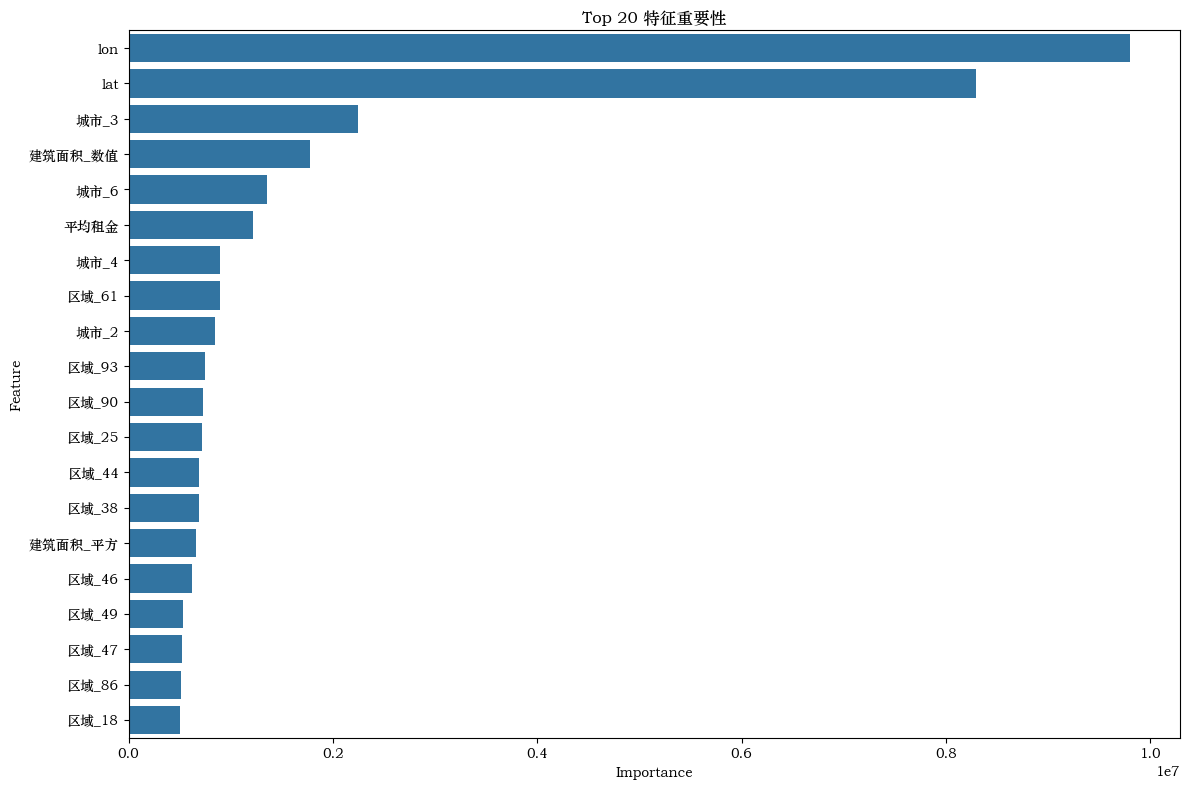


处理测试数据...


In [23]:
# 绘制最佳模型的特征重要性（如果适用）
if hasattr(best_overall_model['model'], 'coef_'):
    plot_feature_importance(best_overall_model['model'], X.columns)

# 处理测试数据并生成提交结果
print("\n处理测试数据...")
X_test_data, X_test_data_scaled, X_test_data_pca = process_data(train_df, test_df, details_df, rent_df, is_training=False)

In [24]:
# 根据最佳模型选择相应的特征集
if "PCA" in best_overall_model['model_name']:
    submission_df = generate_predictions_for_submission(best_overall_model['model'], X_test_data_pca, test_df)
else:
    submission_df = generate_predictions_for_submission(best_overall_model['model'], X_test_data_scaled, test_df)

print("\n分析完成!")


为提交生成预测结果...
测试特征形状: (14897, 562)
测试数据形状: (14786, 31)
预测结果长度: 14897
ID列长度: 14786
警告: ID列和预测结果长度不匹配。进行调整...
预测数量大于ID数量，截断多余预测...
预测结果已保存到 submission.csv

分析完成!
